# Visualising the internals

In [1]:
from math import pi

from matplotlib import pyplot as plt
from numpy.fft import fftshift

from ppdenoise.ppdenoise import _gaussian_angular_filter, _filter_grids, _grid_angles, _gaussian_angular_filter_3d, \
    _filter_grids_3d, _grid_angles_3d

The code assumes the input meshgrid has been created using np.meshgrid with 'ij' indexing. Somewhat confusingly, this results in a cartesian coordinate system with y=0 at the bottom and positive pointing upwards (opposite to regular images).

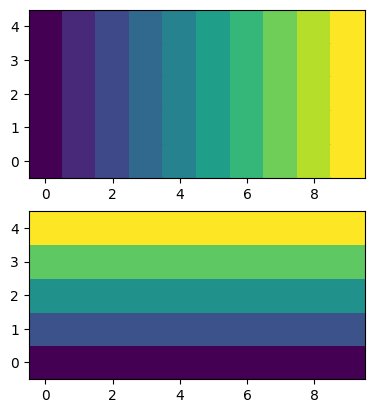

In [2]:
import numpy as np

x, y = np.meshgrid(list(range(10)), list(range(5)), indexing='ij')

fig, axes = plt.subplots(2)
axes[0].pcolor(x, y, x)
axes[1].pcolor(x, y, y)
for ax in axes:
    ax.set_aspect('equal')

Visualisation of the filter components underlying this method, with y=0 at the bottom of the filter.

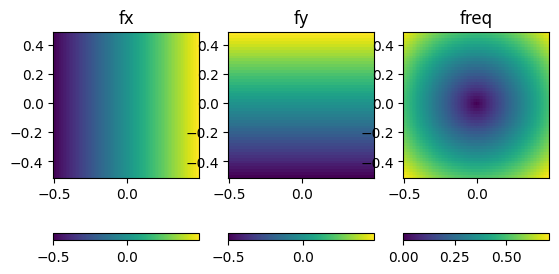

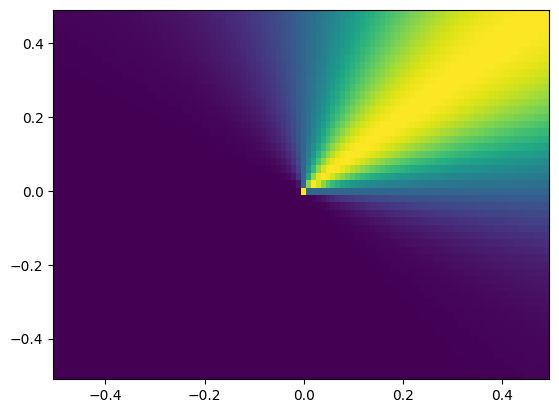

In [3]:
rows, cols = 50, 100
angle_rad = 45 * pi / 180
thetaSigma = pi / 6

freq, fx, fy = _filter_grids(rows, cols)
fx_s = fftshift(fx)
fy_s = fftshift(fy)
freq_s = fftshift(freq)

fig, axes = plt.subplots(1, 3)
cax = axes[0].pcolor(fx_s, fy_s, fx_s)
axes[0].set_title('fx')
fig.colorbar(cax, orientation='horizontal')
cax = axes[1].pcolor(fx_s, fy_s, fy_s)
axes[1].set_title('fy')
fig.colorbar(cax, orientation='horizontal')
cax = axes[2].pcolor(fx_s, fy_s, freq_s)
axes[2].set_title('freq')
fig.colorbar(cax, orientation='horizontal')
for ax in axes:
    ax.set_aspect('equal')

sintheta, costheta = _grid_angles(freq, fx, fy)
sintheta_s = fftshift(sintheta)
costheta_s = fftshift(costheta)
angle_filter = _gaussian_angular_filter(angle_rad, thetaSigma, sintheta, costheta)

fig, ax = plt.subplots()
ax.pcolor(fx_s, fy_s, fftshift(angle_filter))

3D version of the same filters.

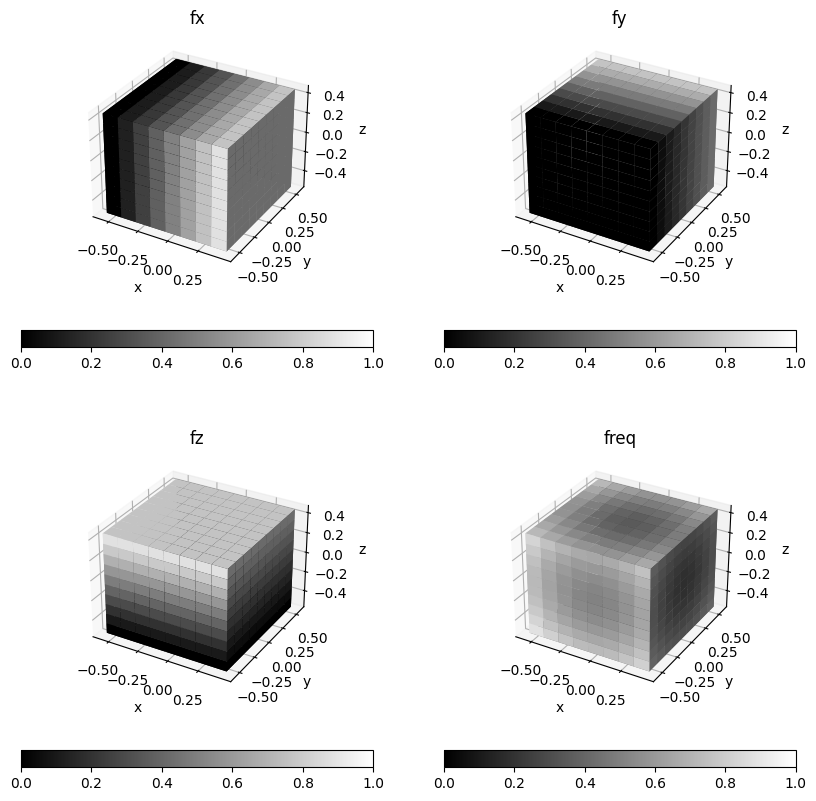

In [4]:
from ppdenoise.ppdenoise import _spaced_frequencies
import numpy as np
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D


def to_edges(centres: list[float]) -> list[float]:
    diffs = np.diff(centres)
    inner_edges = centres[:-1] + diffs / 2
    border_pad = np.median(diffs) / 2
    return [centres[0] - border_pad, *inner_edges, centres[-1] + border_pad]


nx, ny, nz = 8, 9, 10
fx_c, fy_c, fz_c = np.meshgrid(
    to_edges(_spaced_frequencies(nx)),
    to_edges(_spaced_frequencies(ny)),
    to_edges(_spaced_frequencies(nz)),
    indexing='ij'
)
freq, fx, fy, fz = _filter_grids_3d(nx, ny, nz)

# Test axes
fig: plt.Figure
axes: np.ndarray[Axes3D]
fig, axes = plt.subplots(2, 2, subplot_kw={"projection": "3d"})
fig.set_size_inches(10, 10)

for ax, vox, title in zip(axes.flatten(),
                          (fx, fy, fz, freq),
                          ('fx', 'fy', 'fz', 'freq')):
    vox = fftshift(vox)
    m = mpl.cm.ScalarMappable(cmap=plt.cm.gray)
    cax = ax.voxels(fx_c, fy_c, fz_c, np.ones_like(vox),
                    facecolors=mpl.colormaps['gray']((vox - vox.min()) / (vox.max() - vox.min())), alpha=1.0)
    ax.set_title(title)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    m = mpl.cm.ScalarMappable(cmap=plt.cm.gray)
    fig.colorbar(m, ax=ax, orientation='horizontal')

Final 3D filterbank.

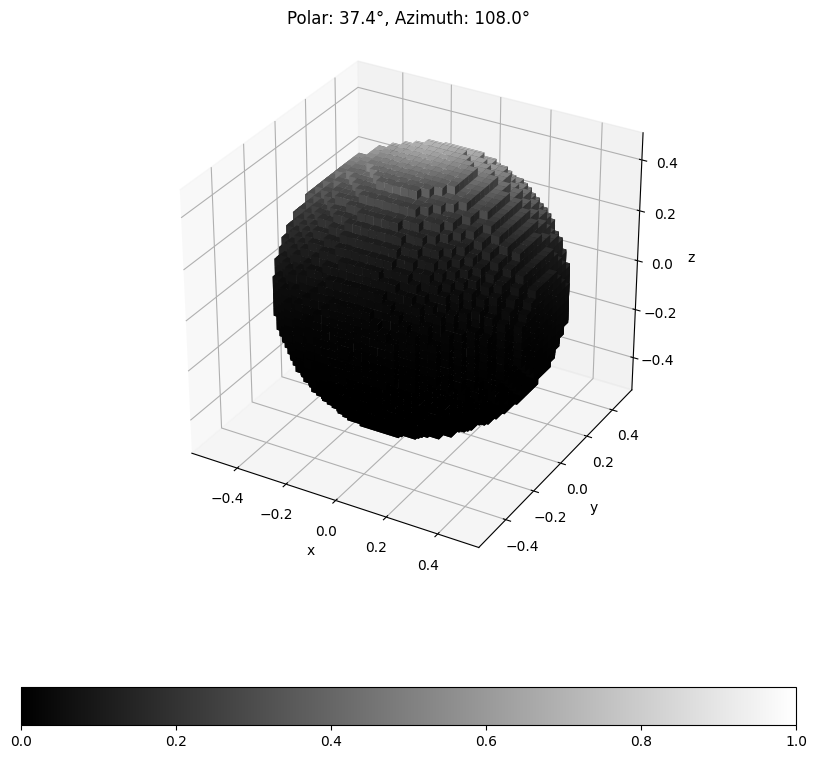

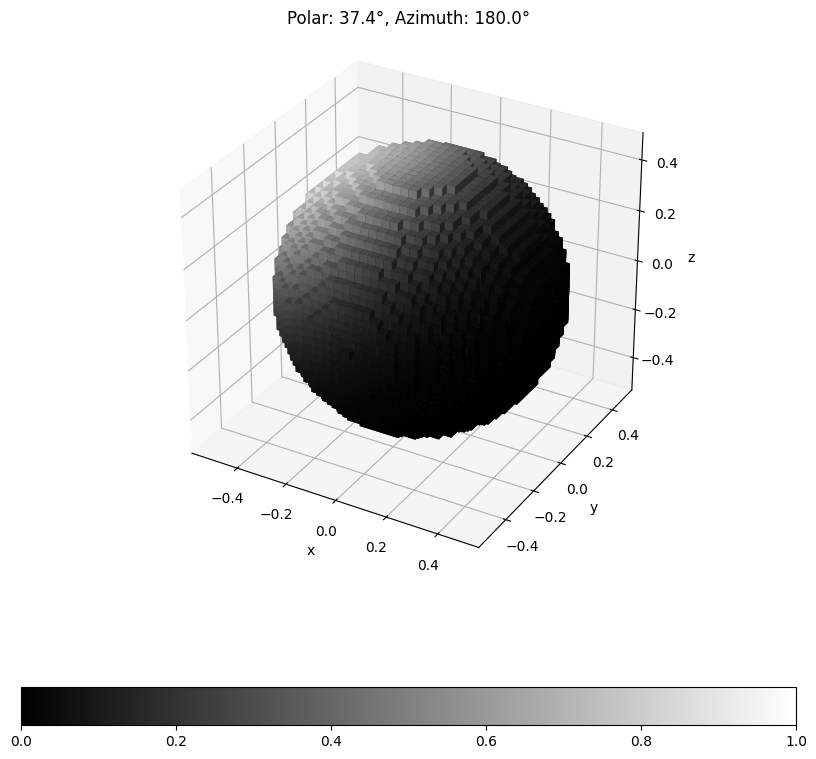

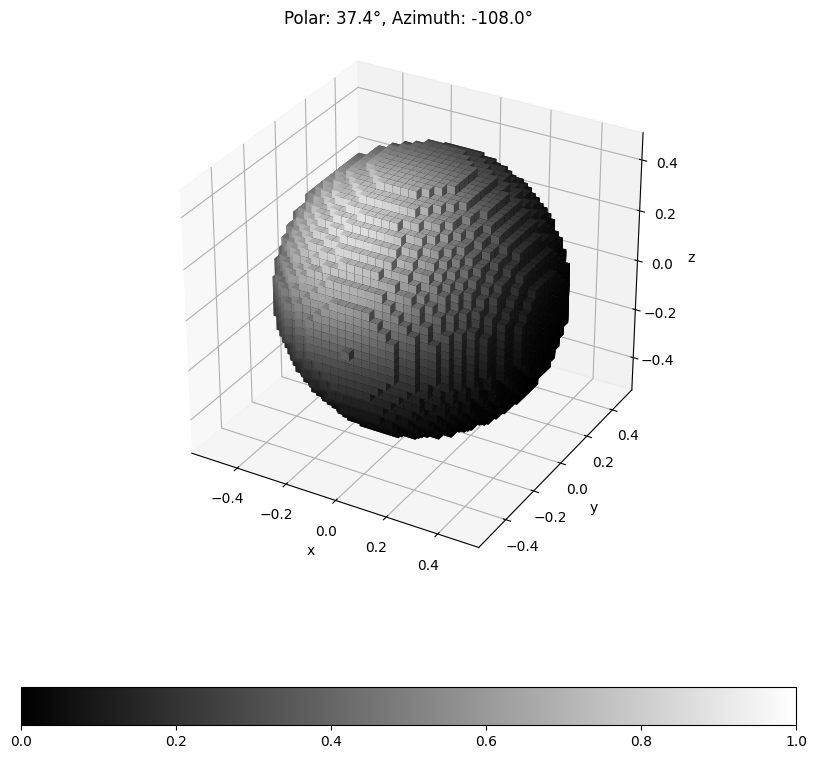

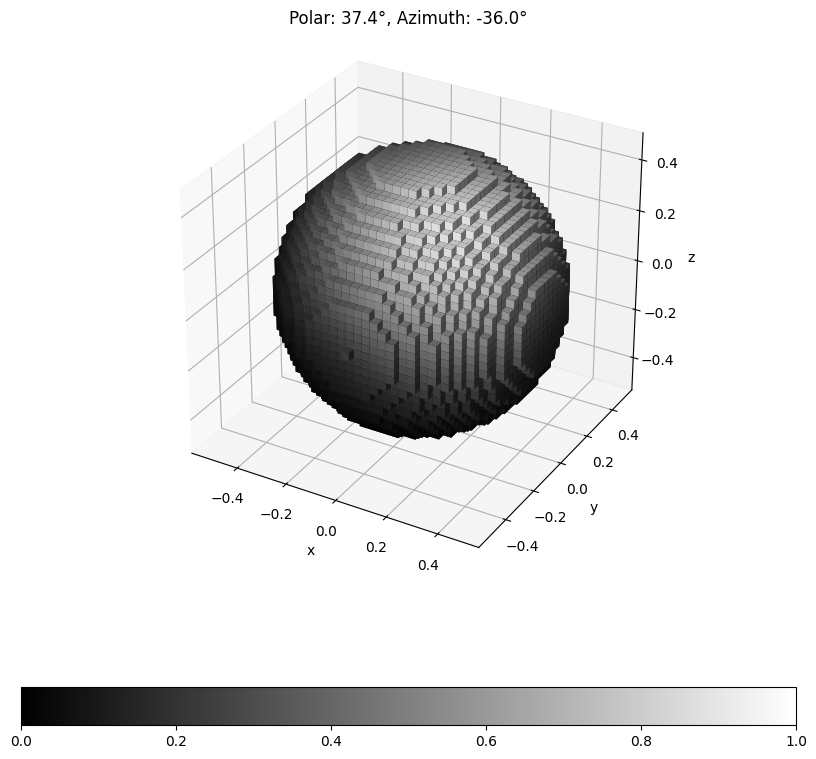

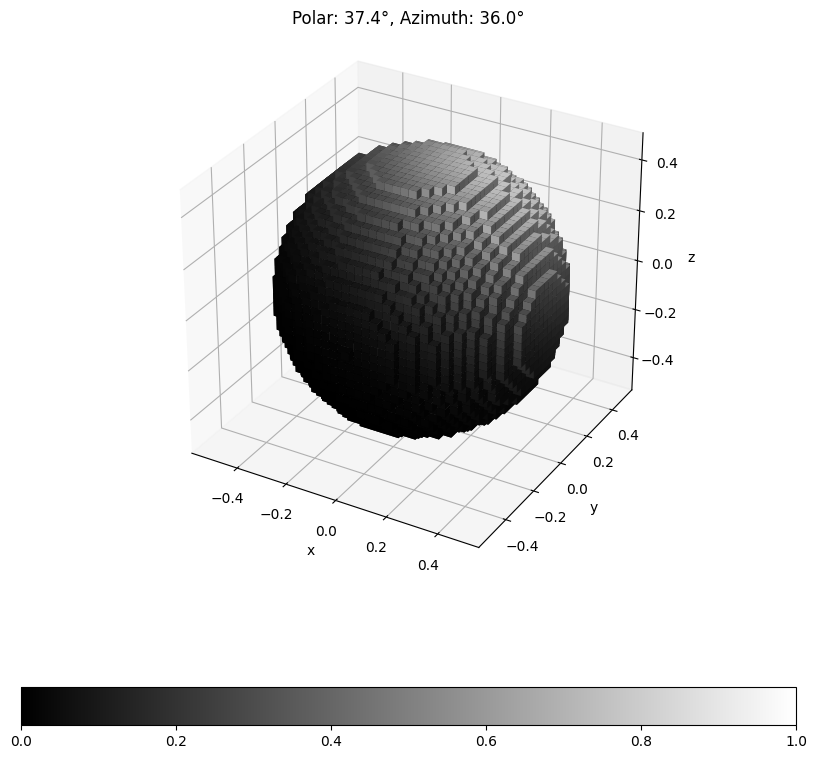

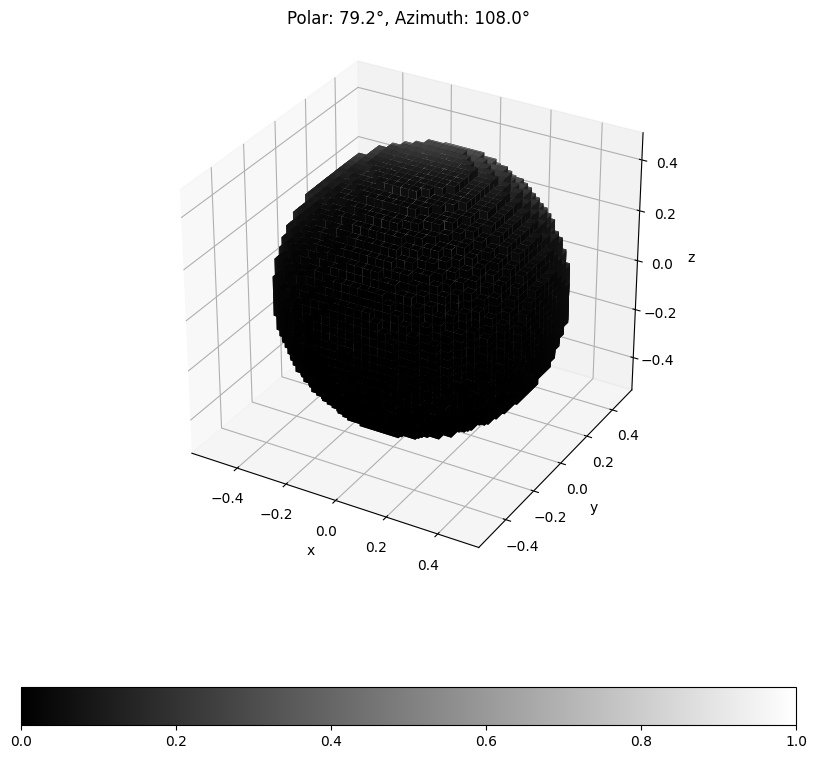

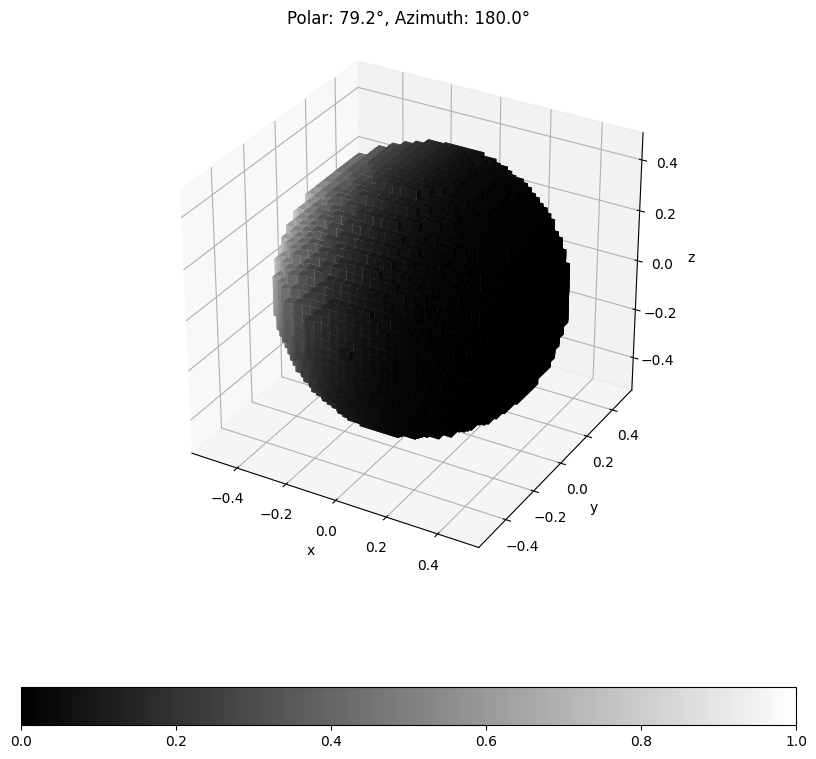

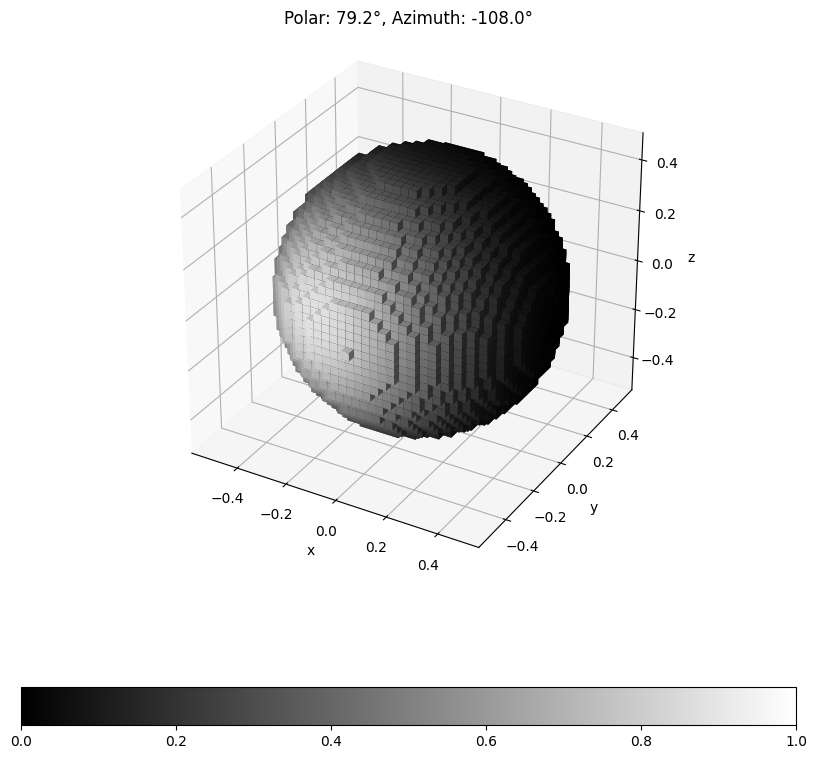

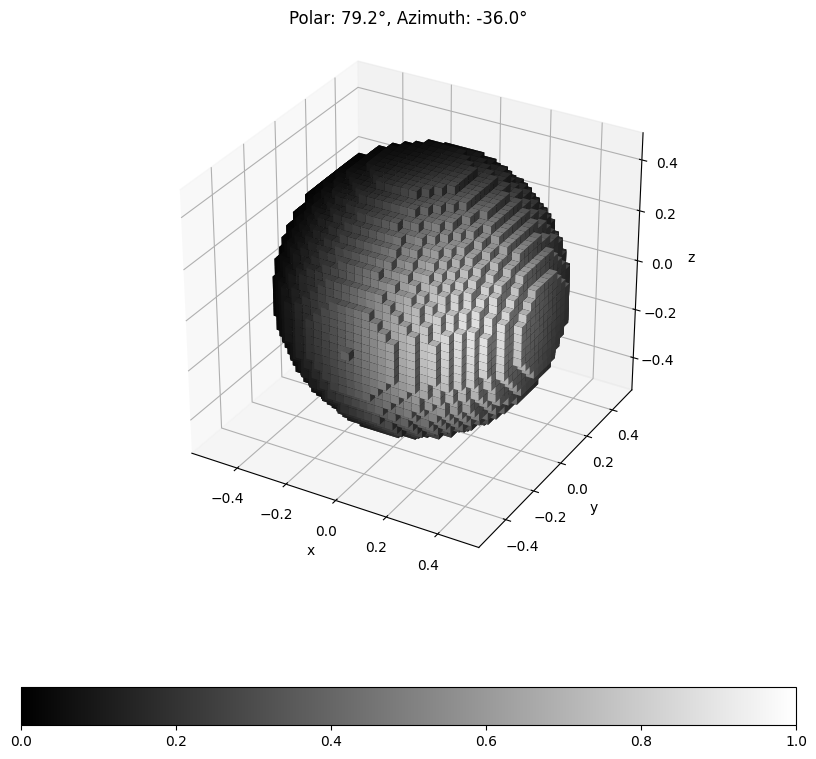

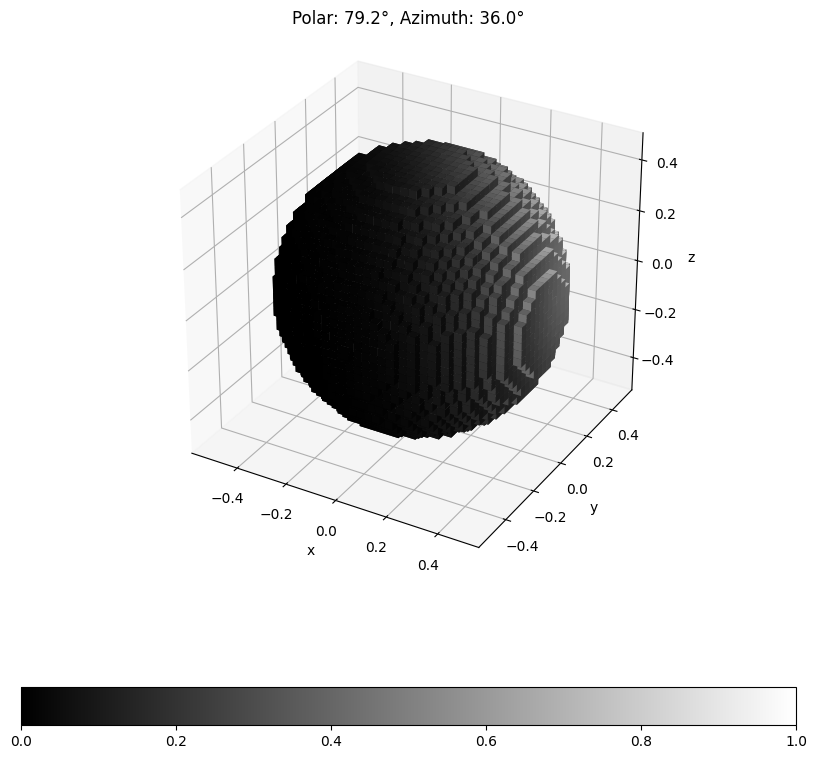

In [5]:
from collections import namedtuple
from math import acos, sqrt, atan
from mpl_toolkits.mplot3d import Axes3D

import numpy as np
import matplotlib as mpl

nx, ny, nz = 32, 32, 32

# Face normals of an icosahedron (top half only). 
Ori3D = namedtuple('Ori3D', ['polar', 'azimuth'])
orientations = [Ori3D(polar=atan(3 - sqrt(5)), azimuth=3 * pi / 5),
                Ori3D(polar=atan(3 - sqrt(5)), azimuth=pi),
                Ori3D(polar=atan(3 - sqrt(5)), azimuth=-3 * pi / 5),
                Ori3D(polar=atan(3 - sqrt(5)), azimuth=-pi / 5),
                Ori3D(polar=atan(3 - sqrt(5)), azimuth=pi / 5),
                Ori3D(polar=atan(3 + sqrt(5)), azimuth=3 * pi / 5),
                Ori3D(polar=atan(3 + sqrt(5)), azimuth=pi),
                Ori3D(polar=atan(3 + sqrt(5)), azimuth=-3 * pi / 5),
                Ori3D(polar=atan(3 + sqrt(5)), azimuth=-pi / 5),
                Ori3D(polar=atan(3 + sqrt(5)), azimuth=pi / 5)]

freq, fx, fy, fz = _filter_grids_3d(nx, ny, nx)
sin_polar, cos_polar, sin_azimuth, cos_azimuth = _grid_angles_3d(freq, fx, fy, fz)
theta_sigma = acos(sqrt(5) / 3)  # icosahedron internal angle

# Make voxel edges (unshifted)
fx_c, fy_c, fz_c = np.meshgrid(
    to_edges(_spaced_frequencies(nx)),
    to_edges(_spaced_frequencies(ny)),
    to_edges(_spaced_frequencies(nz)),
    indexing='ij'
)

for ori in orientations:
    fig: plt.Figure
    ax: Axes3D
    fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
    fig.set_size_inches(10, 10)

    angle_filter = _gaussian_angular_filter_3d(ori.polar, ori.azimuth, theta_sigma, sin_polar, cos_polar, sin_azimuth,
                                               cos_azimuth)
    vox = fftshift(angle_filter)
    m = mpl.cm.ScalarMappable(cmap=plt.cm.gray)
    cax = ax.voxels(fx_c, fy_c, fz_c, fftshift(freq) <= 0.5,
                    facecolors=mpl.colormaps['gray']((vox - vox.min()) / (vox.max() - vox.min())))
    ax.set_title(f'Polar: {ori.polar * 180 / pi:.1f}°, Azimuth: {ori.azimuth * 180 / pi:.1f}°')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    m = mpl.cm.ScalarMappable(cmap=plt.cm.gray)
    fig.colorbar(m, ax=ax, orientation='horizontal')
    ax.set_aspect('equal')


Test that the orientations are working as expected, with polar=0, azimuth=0 pointing directly upwards.

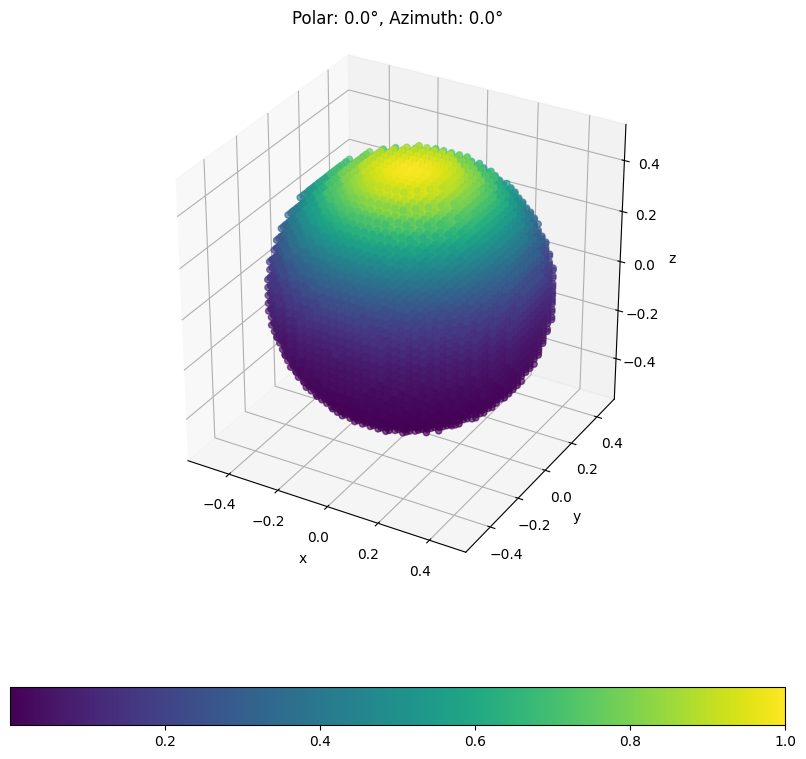

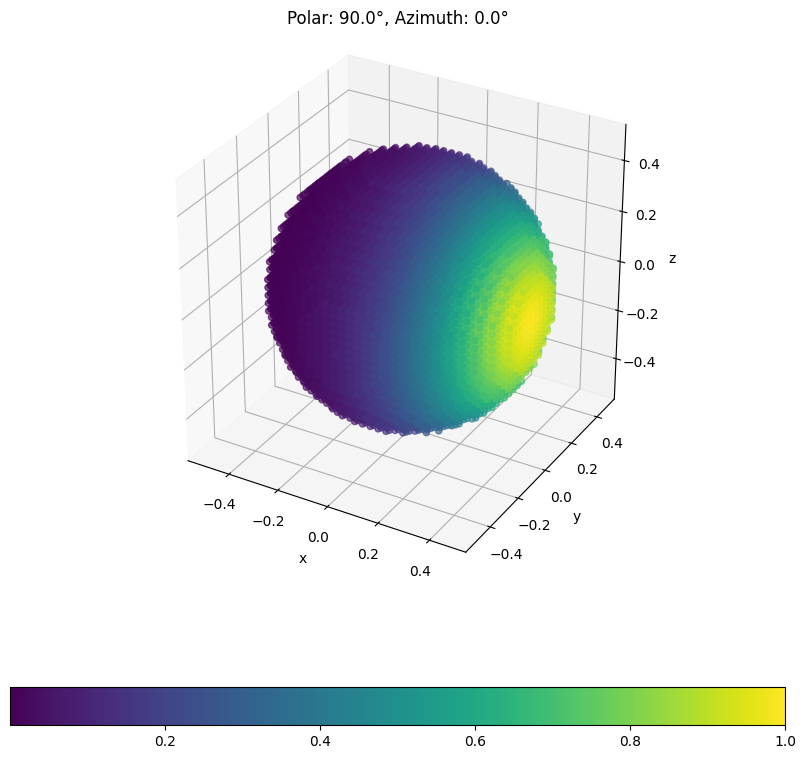

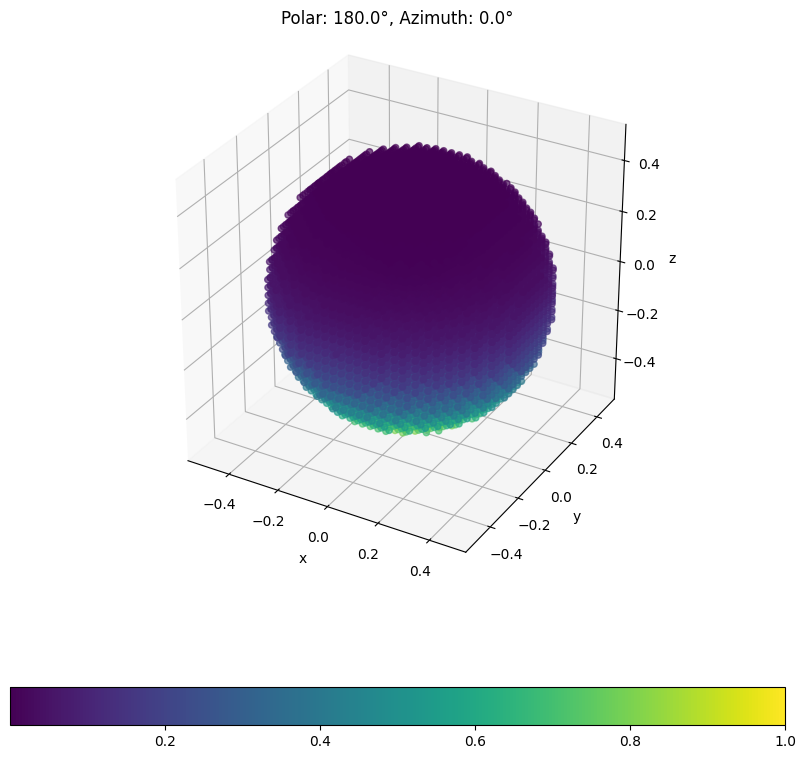

In [6]:
from mpl_toolkits.mplot3d import Axes3D

orientations = [
    Ori3D(polar=0, azimuth=0),
    Ori3D(polar=pi / 2, azimuth=0),
    Ori3D(polar=pi, azimuth=0),
]

for ori in orientations:
    fig: plt.Figure
    ax: Axes3D
    fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
    fig.set_size_inches(10, 10)

    angle_filter = _gaussian_angular_filter_3d(ori.polar, ori.azimuth, theta_sigma, sin_polar, cos_polar, sin_azimuth,
                                               cos_azimuth)
    cax = ax.scatter3D(fx[freq <= 0.5], fy[freq <= 0.5], fz[freq <= 0.5], c=angle_filter[freq <= 0.5])
    ax.set_title(f'Polar: {ori.polar * 180 / pi:.1f}°, Azimuth: {ori.azimuth * 180 / pi:.1f}°')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    fig.colorbar(cax, orientation='horizontal')
    ax.set_aspect('equal')


Generate a noisy volume and denoise using pp3d.

Text(0.5, 0, 'z')

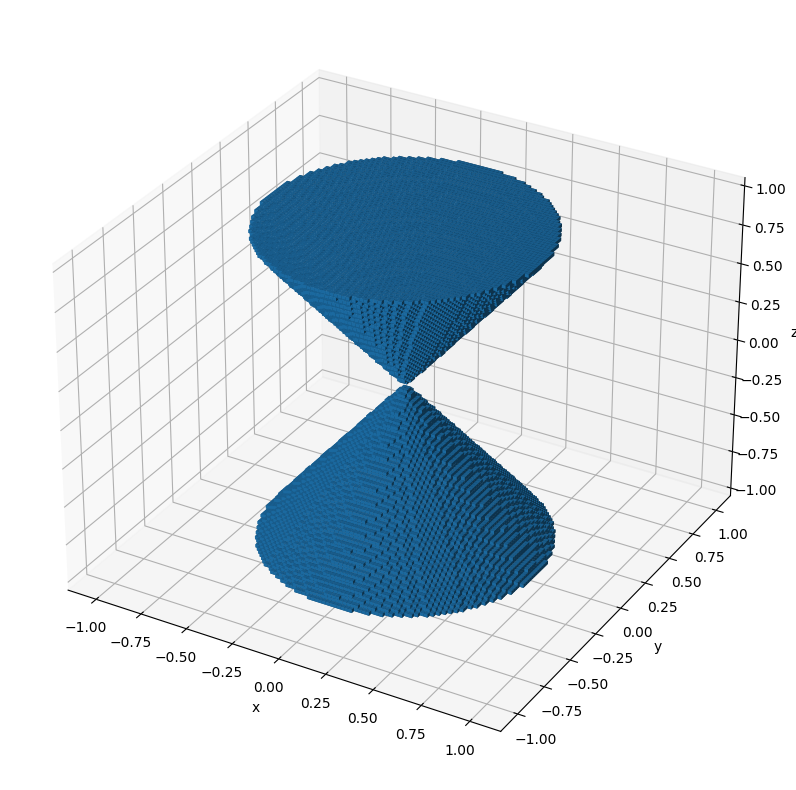

In [7]:
# Make a test volume and test 2D slices and 3D reconstruction
axis_range = np.linspace(-1, 1, 100)
x, y, z = np.meshgrid(axis_range, axis_range, axis_range, indexing='ij')
cone = x**2 + y**2 <= 0.5 * z**2

x_c, y_c, z_c = np.meshgrid(
    to_edges(axis_range),
    to_edges(axis_range),
    to_edges(axis_range),
    indexing='ij'
)

fig: plt.Figure
axes: np.ndarray[Axes3D]
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
fig.set_size_inches(10, 10)
ax.voxels(x_c, y_c, z_c, cone)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')


(array([1.99000e+02, 6.89700e+03, 7.79860e+04, 2.90268e+05, 3.61829e+05,
        1.83346e+05, 6.31220e+04, 1.49380e+04, 1.37400e+03, 4.10000e+01]),
 array([-2.32069568, -1.76242581, -1.20415595, -0.64588608, -0.08761621,
         0.47065365,  1.02892352,  1.58719339,  2.14546325,  2.70373312,
         3.26200299]),
 <BarContainer object of 10 artists>)

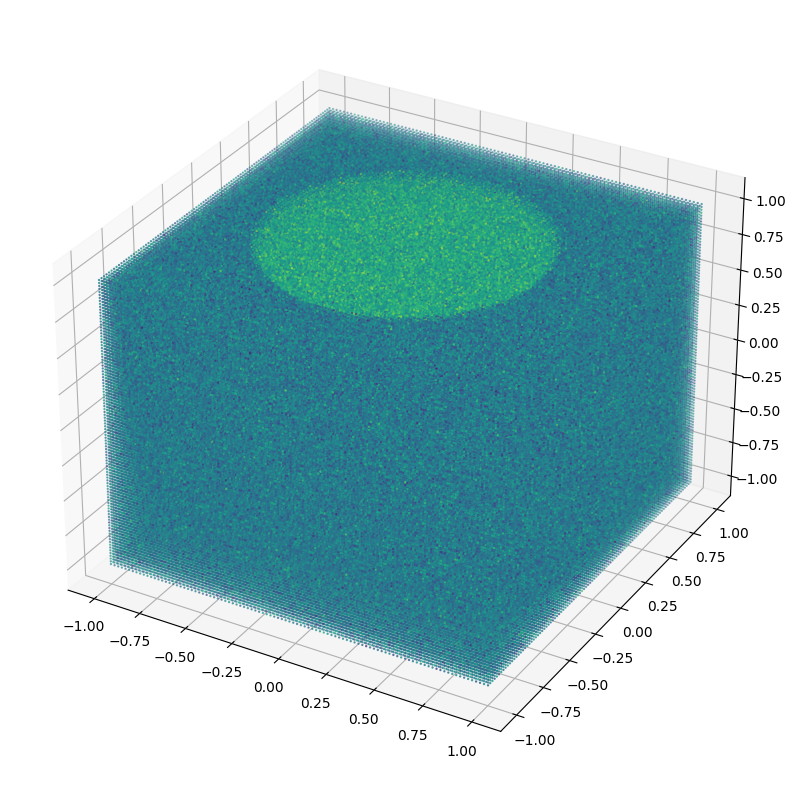

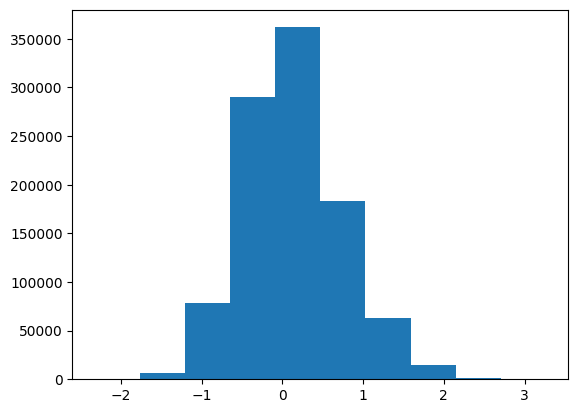

In [8]:
# corrupt with noise
corrupted = np.ones_like(cone) * cone + np.random.normal(0, 0.5, cone.shape)
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
fig.set_size_inches(10, 10)
ax.scatter3D(x, y, z, c=corrupted, s=0.5, edgecolor=None)

fig, ax = plt.subplots()
ax.hist(corrupted.flatten())

Fourier transform of volume
Construct cartesian grids in frequency domain
Construct angular grids in frequency domain
Initialise total energy matrix
Orientation:  Ori3D(polar=0.6523581397843681, azimuth=1.8849555921538759)
Scale:  1
Scale:  2
Scale:  3
Scale:  4
Scale:  5
Orientation:  Ori3D(polar=0.6523581397843681, azimuth=3.141592653589793)
Scale:  1
Scale:  2
Scale:  3
Scale:  4
Scale:  5
Orientation:  Ori3D(polar=0.6523581397843681, azimuth=-1.8849555921538759)
Scale:  1
Scale:  2
Scale:  3
Scale:  4
Scale:  5
Orientation:  Ori3D(polar=0.6523581397843681, azimuth=-0.6283185307179586)
Scale:  1
Scale:  2
Scale:  3
Scale:  4
Scale:  5
Orientation:  Ori3D(polar=0.6523581397843681, azimuth=0.6283185307179586)
Scale:  1
Scale:  2
Scale:  3
Scale:  4
Scale:  5
Orientation:  Ori3D(polar=1.3820857960113346, azimuth=1.8849555921538759)
Scale:  1
Scale:  2
Scale:  3
Scale:  4
Scale:  5
Orientation:  Ori3D(polar=1.3820857960113346, azimuth=3.141592653589793)
Scale:  1
Scale:  2
Scale:  3
Sca

Text(0.5, 0, 'z')

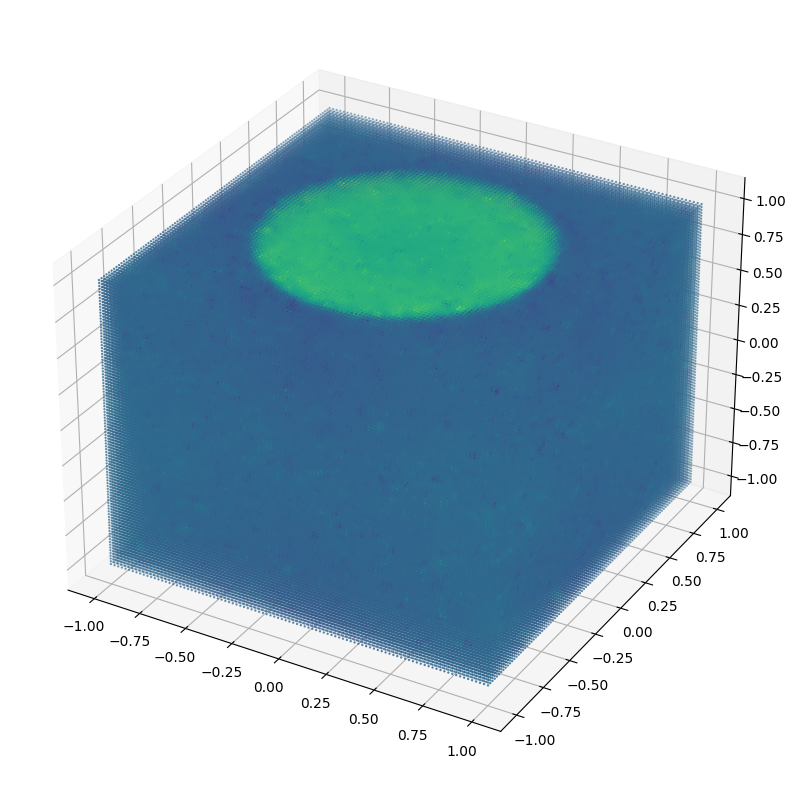

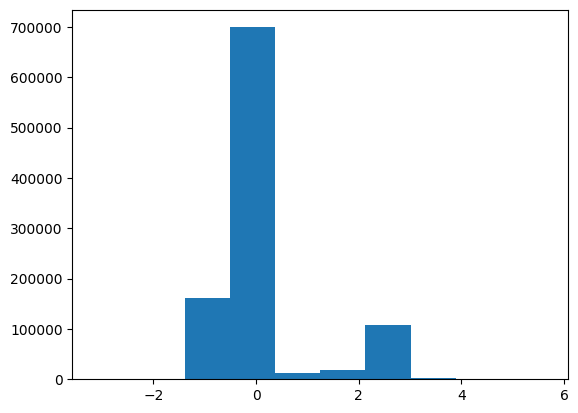

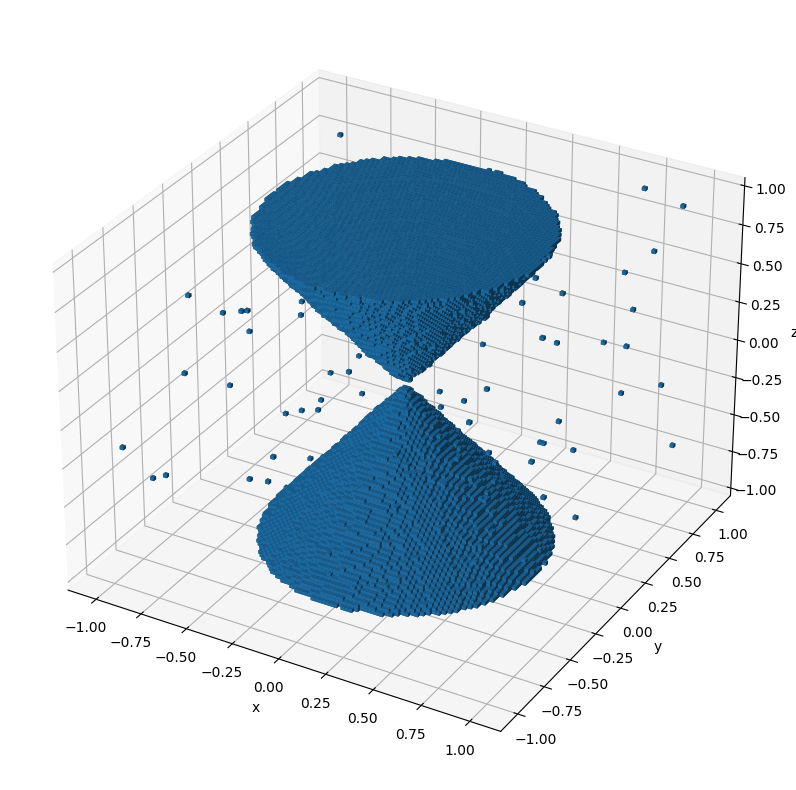

In [9]:
from ppdenoise.ppdenoise import ppdenoise3d

denoised = ppdenoise3d(corrupted)

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
fig.set_size_inches(10, 10)
ax.scatter3D(x, y, z, c=denoised, s=0.5, edgecolor=None)

fig, ax = plt.subplots()
ax.hist(denoised.flatten())

fig: plt.Figure
axes: np.ndarray[Axes3D]
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
fig.set_size_inches(10, 10)
ax.voxels(x_c, y_c, z_c, denoised > 1)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')